# Analysing Attacker 

This notebook contains the code required to conduct a Bayesian data analysis on a list of name, age tuples.

## First attacker

Age, Is Tom?
[[16.  1.]
 [17.  0.]
 [16.  0.]
 [16.  0.]
 [16.  0.]
 [16.  0.]]


AttributeError: module 'pymc3' has no attribute 'rdiscrete_uniform'

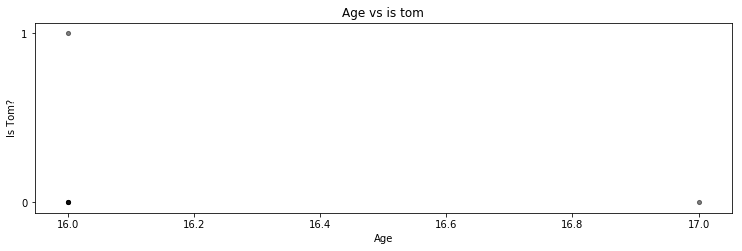

In [1]:
%matplotlib inline
import pymc3 as pm
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as tt
from IPython.core.pylabtools import figsize
from scipy.stats.mstats import mquantiles

def alpha(nameAgeList):
    ageMap = map(lambda args: (args[1], 1), nameAgeList)
    addedAgeTuple = reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]),
                           ageMap)  # In Python 2, the map() built-in function returns an iterator https://thepythonguru.com/python-builtin-functions/map/
    # In Python 2, the map()  function returns a list instead of an iterator (which is not very efficient in terms of memory consumption), so we don’t need to wrap map()  in a list()  call.
    averageAge = addedAgeTuple[0] / addedAgeTuple[1]
    return averageAge

# the attacker knows that Tom n`is in the list

figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
age_data = np.genfromtxt("../data/name_age_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
age_data = age_data[~np.isnan(age_data[:, 1])]

#plot it, as a function of age (the first column)
print("Age, Is Tom?")
print(age_data)

plt.scatter(age_data[:, 0], age_data[:, 1], s=17, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Is Tom?")
plt.xlabel("Age")
plt.title("Age vs is tom")

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

age = age_data[:, 0]
D = age_data[:, 1]  # is_tom or not?

with pm.Model() as model:
    beta = pm.Normal("beta", mu=16, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=17, tau=0.001, testval=0)
    # constant = pm.Constant()
    example = pm.rdiscrete_uniform(0,80)
    print("example" + example)
    
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*age + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.sample()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]
    
    alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
    beta_samples = burned_trace["beta"][:, None]
    
    figsize(12.5, 6)
    
    #histogram of the samples:
    plt.subplot(211)
    plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
    plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
             label=r"posterior of $\beta$", color="#7A68A6", normed=True)
    plt.legend()
    
    plt.subplot(212)
    plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
             label=r"posterior of $\alpha$", color="#A60628", normed=True)
    plt.legend()
    
    
    t = np.linspace(age.min() - 5, age.max()+5, 50)[:, None]
    p_t = logistic(t.T, beta_samples, alpha_samples)
    
    mean_prob_t = p_t.mean(axis=0)
    
    figsize(12.5, 4)

    plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
    of defect")
    plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
    plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
    plt.scatter(age, D, color="k", s=50, alpha=0.5)
    plt.title("Posterior expected value of probability of tom in list; \
    plus realizations")
    plt.legend(loc="lower left")
    plt.ylim(-0.1, 1.1)
    plt.xlim(t.min(), t.max())
    plt.ylabel("probability")
    plt.xlabel("age")
    # vectorized bottom and top 2.5% quantiles for "confidence interval"
    qs = mquantiles(p_t, [0.025, 0.975], axis=0)
    plt.fill_between(t[:, 0], *qs, alpha=0.7,
                     color="#7A68A6")
    
    plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
    
    plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
             label="average posterior \nprobability of defect")
    
    plt.xlim(t.min(), t.max())
    plt.ylim(-0.02, 1.02)
    plt.legend(loc="lower left")
    plt.scatter(age, D, color="k", s=50, alpha=0.5)
    plt.xlabel("age, $age$")
    
    plt.ylabel("probability estimate")
    plt.title("Posterior probability estimates given age. $age$");